# Classification

In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt

In [ ]:
url = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip'
! wget $url

In [2]:
ddir = ! pwd

In [3]:
ddir[0]

'/home/jovyan/work/i2p/lectures'

In [4]:
gdf = gpd.read_file(f"zip:///{ddir[0]}/statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   MSOA11CD   983 non-null    object  
 1   MSOA11NM   983 non-null    object  
 2   LAD11CD    983 non-null    object  
 3   LAD11NM    983 non-null    object  
 4   RGN11CD    983 non-null    object  
 5   RGN11NM    983 non-null    object  
 6   USUALRES   983 non-null    int64   
 7   HHOLDRES   983 non-null    int64   
 8   COMESTRES  983 non-null    int64   
 9   POPDEN     983 non-null    float64 
 10  HHOLDS     983 non-null    int64   
 11  AVHHOLDSZ  983 non-null    float64 
 12  geometry   983 non-null    geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 100.0+ KB


In [37]:
df = pd.read_csv('https://data.london.gov.uk/download/average-house-prices/bdf8eee7-41e1-4d24-90ce-93fe5cf040ae/land-registry-house-prices-MSOA.csv', na_values=[':'], low_memory=False)

,Value
count,2.624410e+05
mean,1.891555e+05
std,2.301464e+05
min,2.000000e+00
25%,1.690000e+02
50%,1.547800e+05
75%,2.757430e+05
max,5.408967e+06


In [38]:
print(df.shape)
measure = 'Mean'
year = 2017
df = df[(df.Year==f'Year ending Dec {year}') & (df.Measure==measure)].copy().reset_index()
df.drop(index=df[df.Value.isna()].index, inplace=True)
print(df.shape)

(262461, 5)
(983, 6)


In [41]:
df['Measure'] = df.Measure.astype('category')
df['Value'] = df.Value.astype('int')
df.drop(columns=['index'], inplace=True)

In [45]:
ppd = pd.merge(gdf, df, left_on='MSOA11CD', right_on='Code', how='inner').reset_index()
ppd.shape

(983, 19)

In [51]:
ppd[ppd.Value.isin([ppd.Value.max(), ppd.Value.min()])][['index','MSOA11CD','MSOA11NM','Value']]

,index,MSOA11CD,MSOA11NM,Value
14,14,E02000016,Barking and Dagenham 015,226536
945,945,E02000978,Westminster 019,4416659


In [52]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [53]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

In [59]:
def highlight_min(ax, gdf, c='r'):
    gdf[gdf.Value==gdf.Value.min()].plot(facecolor='None', edgecolor=c, ax=ax)
    
def highlight_max(ax, gdf, c='r'):
    gdf[gdf.Value==gdf.Value.max()].plot(facecolor='None', edgecolor=c, ax=ax)

### Raw Distribution

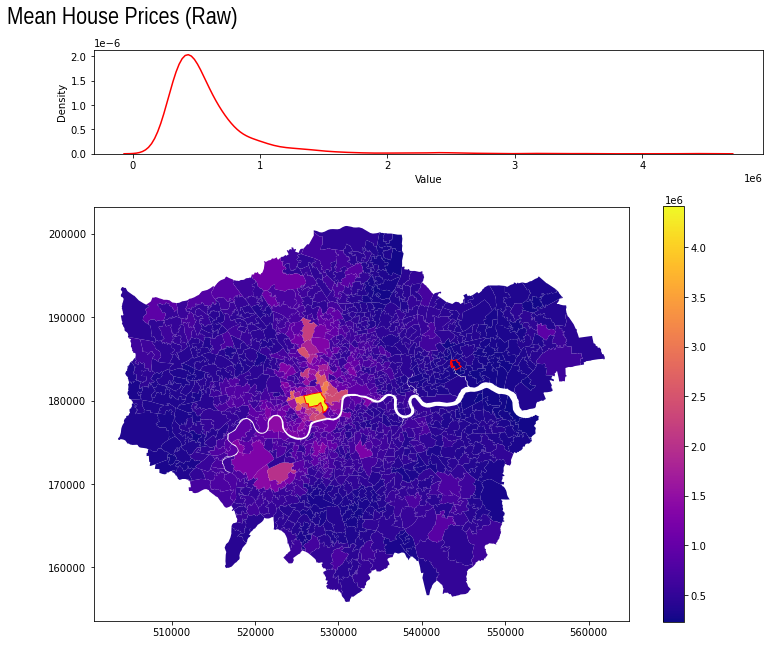

In [60]:
f = plt.figure(constrained_layout=False)
f.set_size_inches(12, 10)
gs = f.add_gridspec(nrows=2, ncols=1, height_ratios=[1,4])

ax1 = f.add_subplot(gs[0,0])
sns.kdeplot(df.Value, ax=ax1, color='r')

ax2 = f.add_subplot(gs[1,0])
ppd.plot(column='Value', legend=True, cmap='plasma', figsize=(12,6), ax=ax2)
highlight_min(ax2, ppd)
highlight_max(ax2, ppd)
f.subplots_adjust(top=0.92)
f.suptitle(f"{measure} House Prices (Raw)", x=0.025, size=24, **tfont);
plt.savefig('House-Prices-Raw.png', dpi=150)

### Manual Breaks (Based on SDLT)

In [26]:
from math import ceil

4500000

In [62]:
# https://aspenwoolf.co.uk/what-is-stamp-duty-2019/
m = mapclassify.UserDefined(ppd.Value, bins=[125000, 250000, 925000, 1500000, ceil(df.Value.max()/100000)*100000])
print(m.bins)
print(m)

[ 125000  250000  925000 1500000 4500000]
UserDefined                     

        Interval           Count
--------------------------------
(      -inf,  125000.00] |     0
( 125000.00,  250000.00] |     4
( 250000.00,  925000.00] |   865
( 925000.00, 1500000.00] |    85
(1500000.00, 4500000.00] |    29


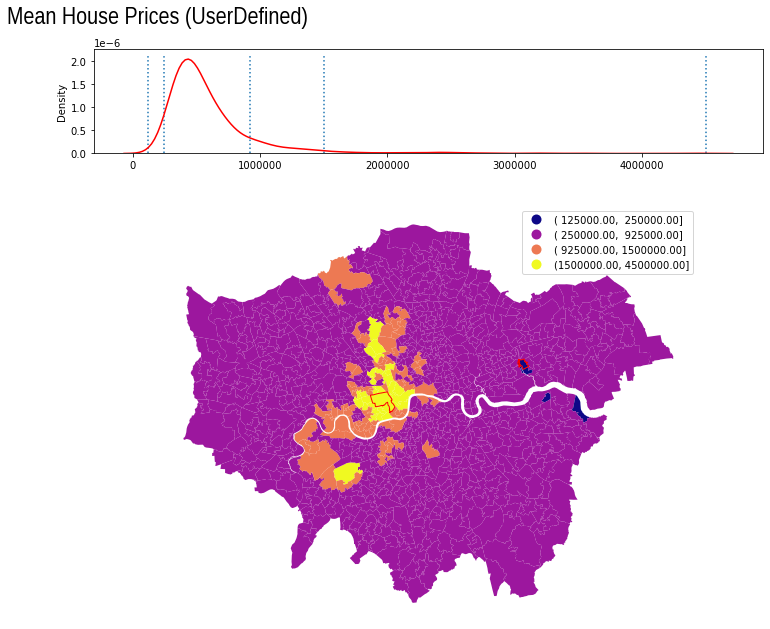

In [70]:
f = plt.figure(constrained_layout=False)
f.set_size_inches(12, 10)
gs = f.add_gridspec(nrows=2, ncols=1, height_ratios=[1,4])

ax1 = f.add_subplot(gs[0,0])
sns.kdeplot(ppd.Value, ax=ax1, color='r')
ax1.ticklabel_format(style='plain', axis='x') 
ax1.set_xlabel(None)

y = ax1.get_ylim()[1]
for b in m.bins:
    ax1.vlines(b, 0, y, linestyles='dotted')
    
ax2 = f.add_subplot(gs[1,0])
ppd.assign(cl=m.yb).plot(column='cl', k=len(m.bins), categorical=True, legend=True, cmap='plasma', figsize=(12,6), ax=ax2)
highlight_min(ax2, ppd)
highlight_max(ax2, ppd)

mapping = dict([(i,s) for i,s in enumerate(m.get_legend_classes())])
ax2.set_axis_off()
replace_legend_items(ax2.get_legend(), mapping)

f.subplots_adjust(top=0.92)
f.suptitle(f"{measure} House Prices ({m.__class__.__name__})", x=0.025, size=24, **tfont);
plt.savefig('House-Prices-User_Defined.png', dpi=150)
plt.close()

### Classifiers

In [76]:
kl = 7
cls = [mapclassify.BoxPlot, mapclassify.StdMean, mapclassify.MaxP, 
       mapclassify.HeadTailBreaks, mapclassify.EqualInterval, mapclassify.Quantiles,
       mapclassify.NaturalBreaks, mapclassify.MaximumBreaks, mapclassify.FisherJenks, 
       mapclassify.JenksCaspall]
       
for cl in cls:
    try: 
        m = cl(ppd.Value, k=kl)
    except TypeError:
        m = cl(ppd.Value)
    #m = mapclassify.UserDefined(ppd.Value, bins=[125000, 250000, 925000, 1500000, ceil(df.Value.max()/100000)*100000])
    print(m.__class__.__name__)
    print(m.bins)
    print(m)
    
    f = plt.figure(constrained_layout=False)
    f.set_size_inches(12, 10)
    gs = f.add_gridspec(nrows=2, ncols=1, height_ratios=[1,4])

    ax1 = f.add_subplot(gs[0,0])
    sns.kdeplot(ppd.Value, ax=ax1, color='r')
    ax1.ticklabel_format(style='plain', axis='x') 
    ax1.set_xlabel(None)

    y = ax1.get_ylim()[1]
    for b in m.bins:
        ax1.vlines(b, 0, y, linestyles='dotted')

    ax2 = f.add_subplot(gs[1,0])
    ppd.assign(cl=m.yb).plot(column='cl', k=len(m.bins), categorical=True, legend=True, cmap='plasma', figsize=(12,8), ax=ax2)
    highlight_min(ax2, ppd)
    highlight_max(ax2, ppd)
    
    mapping = dict([(i,s) for i,s in enumerate(m.get_legend_classes())])
    ax2.set_axis_off()
    replace_legend_items(ax2.get_legend(), mapping)

    f.subplots_adjust(top=0.92)
    f.suptitle(f"{measure} House Prices ({m.__class__.__name__})", x=0.025, size=24, **tfont);
    plt.savefig(f"House-Prices-{m.__class__.__name__}.png", dpi=150);
    plt.close()
    print()

BoxPlot
[ -31429.25  391267.    495010.    673064.5  1095760.75 4416659.  ]
BoxPlot                         

        Interval           Count
--------------------------------
(      -inf,  -31429.25] |     0
( -31429.25,  391267.00] |   246
( 391267.00,  495010.00] |   246
( 495010.00,  673064.50] |   245
( 673064.50, 1095760.75] |   176
(1095760.75, 4416659.00] |    70

EqualInterval
[ 825125. 1423714. 2022303. 2620892. 3219481. 3818070. 4416659.]
EqualInterval                   

        Interval           Count
--------------------------------
[ 226536.00,  825125.00] |   842
( 825125.00, 1423714.00] |   108
(1423714.00, 2022303.00] |    17
(2022303.00, 2620892.00] |    10
(2620892.00, 3219481.00] |     4
(3219481.00, 3818070.00] |     1
(3818070.00, 4416659.00] |     1

MaxP
[ 346594  461577  529197  530662  613465  842387 4416659]
MaxP                            

        Interval           Count
--------------------------------
[ 226536.00,  346594.00] |   142
( 346594.00,  4615